# Batch run of the environment model 
for higher quality results

## Batch run

In [1]:
import seaborn as sns
from schema import *
from typing import Dict, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

c:\Users\svoelkl\source\repos\Studium\02. Symbolische KI\Catastrophe-Simulator\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if iterables: tries all possible combinations of the parameters
parameters: Dict = {
    "width": range(8, 25, 2),
    "height": range(8, 25, 2),
    "n_survivors": range(1, 11),
    "n_save_zones": range(1, 11),
    "n_robot_agents": range(1, 7),
    "seed": 42,
}

# calculate the number of iterations for all parameters
count = 1
for key, value in parameters.items():
    # value can be a list or a range
    if isinstance(value, range):
        count *= len(list(value))
    elif isinstance(value, list):
        count *= len(value)
print("Count of combinations:", count)

Count of combinations: 48600


In [3]:
# if true -> run batch
# if false -> load pickle file from output folder
run_batch = True

In [4]:
if run_batch:
    batch_results = mesa.batch_run(
        model_cls=EnvironmentModel,
        parameters=parameters,
        iterations=1, # for each possible combination of parameters
        number_processes=None,
        data_collection_period=-1,
        display_progress=True,
        max_steps=1000,
    )
    # auto multiprocessing if number_processes is None

100%|██████████| 48600/48600 [1:01:33<00:00, 13.16it/s]


In [5]:
PICKLE_FILE = "./output/batch_results.pkl"
df: pd.DataFrame = None

if run_batch:
    df = pd.DataFrame(batch_results)
    pd.DataFrame.to_pickle(df, PICKLE_FILE)

else:
    # load the results from the pickle file
    try:
        df = pd.DataFrame(pd.read_pickle(PICKLE_FILE))
    except:
        print("batch results not available, file not found, etc.")

print(f"The results have {len(df)} rows.")
print(f"The results have {len(df.columns)} columns.")
print("Columns:")
print(df.columns)
df.head()

The results have 170100 rows.
The results have 29 columns.
Columns:
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'seed', 'Survivors', 'SaveZones',
       'MazeWidth', 'MazeHeight', 'AllSurvivorsRescued', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'AgentID', 'Tile', 'TransportedSurvivor', 'TilesMoved',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'StillRunning'],
      dtype='object')


,RunId,iteration,Step,width,height,n_survivors,n_save_zones,n_robot_agents,seed,Survivors,...,TotalTilesMoved,TotalSurvivorsPickedUp,TotalSurvivorsPlacedDown,AgentID,Tile,TransportedSurvivor,TilesMoved,SurvivorsPickedUp,SurvivorsPlacedDown,StillRunning
0,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x00000179D8A10830>],...,12,4,0,1,<schema.Tile object at 0x00000179D89CE710>,None,12,1,1,True
1,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x00000179D8A10830>],...,12,4,0,2,<schema.Tile object at 0x00000179D89F4770>,<schema.Survivor object at 0x00000179D89CE850>,0,1,0,False
2,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x00000179D8A10830>],...,12,4,0,3,<schema.Tile object at 0x00000179D89F4770>,<schema.Survivor object at 0x00000179D89CE850>,0,1,0,False
3,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x00000179D8A10830>],...,12,4,0,4,<schema.Tile object at 0x00000179D89F4770>,<schema.Survivor object at 0x00000179D89CE850>,0,1,0,False
4,4,0,4,8,8,1,1,5,42,[<schema.Survivor object at 0x00000179D89CEAD0>],...,12,5,0,1,<schema.Tile object at 0x00000179D8A20050>,None,12,1,1,True


## Data transformation

In [6]:

# drop cols
df.drop(
    [
        "seed", 
        "Survivors", 
        "SaveZones", 
        "MazeWidth", 
        "MazeHeight", 
        "AllSurvivorsRescued", 
        "Tile", 
        "StillRunning",
        "AgentID",
        "TransportedSurvivor",
        "TilesMoved"
    ],
    axis=1,
    inplace=True,
)
print(f"The results have reduced {len(df.columns)} columns.")
print(df.columns)

# get the ratio of TilesMoved per SurvivorCount as the column "TilesMovedPerSurvivor"
df["TilesMovedPerSurvivor"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_survivors"] if x["n_survivors"] > 0 else 0, axis=1
)

# get the ratio of TilesMoved per SaveZoneCount as the column "TilesMovedPerSaveZone"
df["TilesMovedPerSaveZone"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_save_zones"] if x["n_save_zones"] > 0 else 0,
    axis=1,
)

# get pathlengths parameters. only works if data_collection_period is set to 1
df["PathlengthMin"] = df.apply(
    lambda x: EnvironmentModel.get_min_pathlength(
        x["InitialPathlengths"]
    ),
    axis=1,
)
df["PathlengthMax"] = df.apply(
    lambda x: EnvironmentModel.get_max_pathlength(x["InitialPathlengths"]),
    axis=1,
)
df["PathlengthMean"] = df.apply(
    lambda x: EnvironmentModel.get_mean_pathlength(x["InitialPathlengths"]),
    axis=1,
)

# grouping of survivor / save zone / robot counts
df["SurvivorCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_survivors"] < 5 else "High (>=5)", axis=1
)
df["SaveZoneCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_save_zones"] < 5 else "High (>=5)", axis=1
)
df["RobotCountGroup"] = df.apply(
    lambda x: "Low (<4)" if x["n_robot_agents"] < 3 else "High (>=4)", axis=1
)

# height * width
df["MazeSize"] = df.apply(
    lambda x: x["width"] * x["height"], axis=1
)

The results have reduced 18 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown'],
      dtype='object')


## Data analysis

### Correlation matrix of chosen cols

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'TilesMovedPerSurvivor',
       'TilesMovedPerSaveZone', 'PathlengthMin', 'PathlengthMax',
       'PathlengthMean', 'SurvivorCountGroup', 'SaveZoneCountGroup',
       'RobotCountGroup', 'MazeSize'],
      dtype='object')


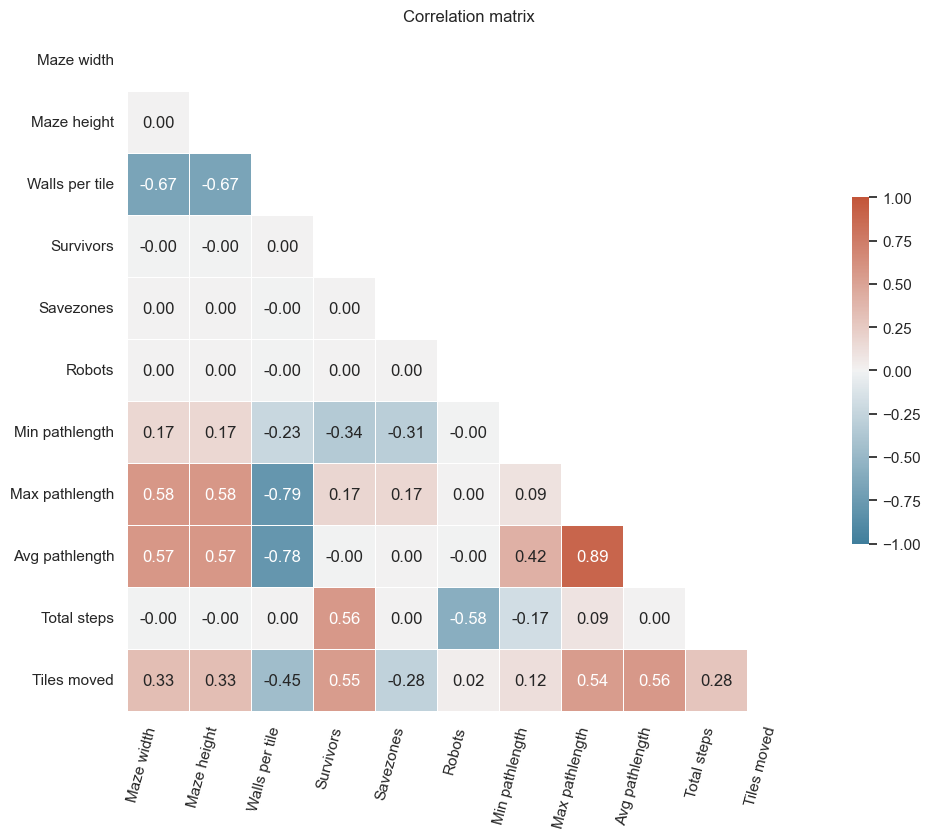

In [7]:
# choose some columns
print(df.columns)
df_corr = df.reset_index()
df_corr = df_corr[
    [
        "width",
        "height",
        "MeanWallDensity",
        "n_survivors",
        "n_save_zones",
        "n_robot_agents",
        "PathlengthMin",
        "PathlengthMax",
        "PathlengthMean",
        "Step",
        "TotalTilesMoved",
        # "TilesMovedPerSurvivor",
        # "TilesMovedPerSaveZone",
    ]
]
df_corr.rename(
    columns={
        "width": "Maze width",
        "height": "Maze height",
        "MeanWallDensity": "Walls per tile",
        "n_survivors": "Survivors",
        "n_save_zones": "Savezones",
        "n_robot_agents": "Robots",
        "PathlengthMin": "Min pathlength",
        "PathlengthMax": "Max pathlength",
        "PathlengthMean": "Avg pathlength",
        "Step": "Total steps",
        "TotalTilesMoved": "Tiles moved",
    },
    inplace=True,
)

corr = df_corr.corr()

# Correlation matrix with mask for upper triangle as matplotlib figure
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
)
plt.title("Correlation matrix")
plt.xticks(rotation=75, ha="right")
plt.savefig("./output/correlation_heatmap.png", dpi=300, bbox_inches="tight")

### Impact of features on the total tiles moved
#### TilesMoved x Survivors

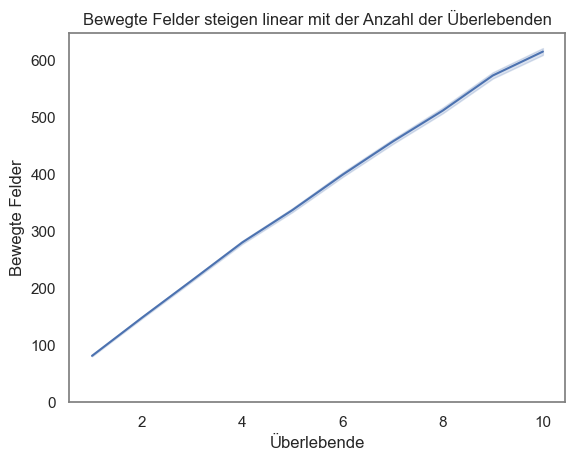

In [8]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved")
plt.title("Bewegte Felder steigen linear mit der Anzahl der Überlebenden")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")
    
plt.savefig("./output/tiles_moved_per_survivor.png", dpi=300, bbox_inches="tight")

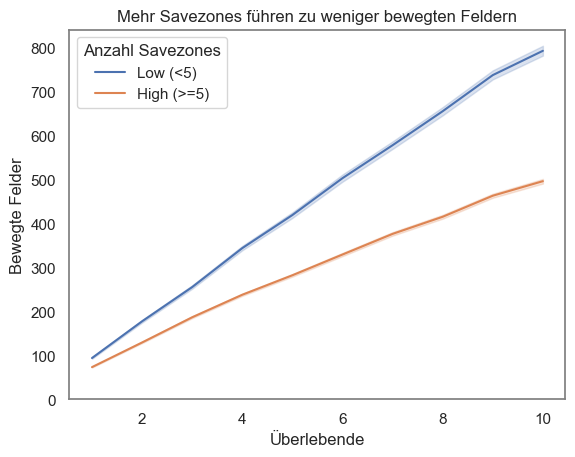

In [9]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="SaveZoneCountGroup")
plt.title("Mehr Savezones führen zu weniger bewegten Feldern")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)
plt.legend(title="Anzahl Savezones")
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/tiles_moved_per_survivor_grouped_savezones.png", dpi=300, bbox_inches="tight")

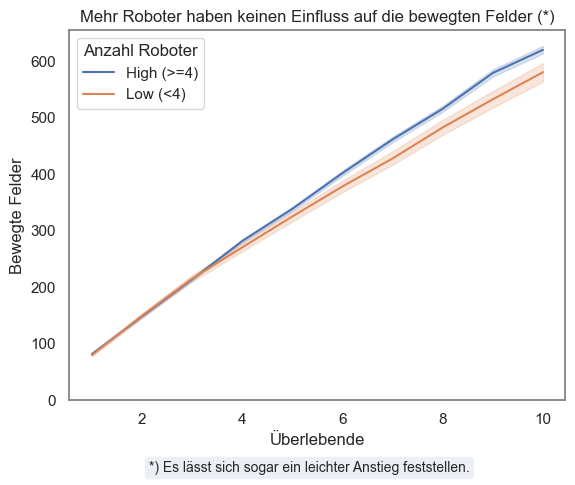

In [10]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="RobotCountGroup")
plt.title("Mehr Roboter haben keinen Einfluss auf die bewegten Felder (*)")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)

plt.legend(title="Anzahl Roboter")
plt.figtext(
    0.5,
    -0.04,
    "*) Es lässt sich sogar ein leichter Anstieg feststellen.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/tiles_moved_per_survivor_grouped_robots.png", dpi=300, bbox_inches="tight"
)

#### Pathlength x SaveZones

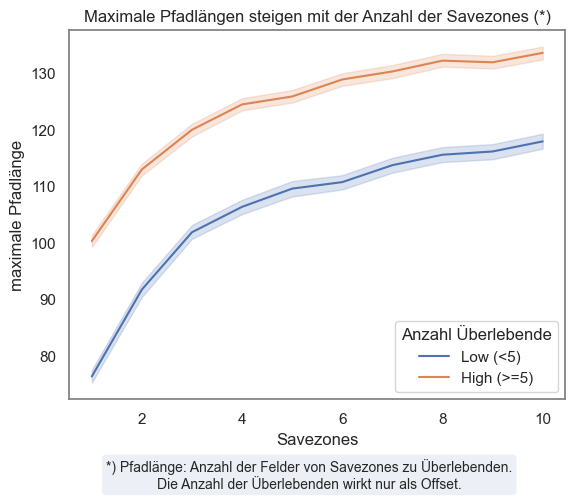

In [11]:
sns.lineplot(data=df, x="n_save_zones", y="PathlengthMax", hue="SurvivorCountGroup")

plt.title("Maximale Pfadlängen steigen mit der Anzahl der Savezones (*)")
plt.xlabel("Savezones")
plt.ylabel("maximale Pfadlänge")

plt.legend(title="Anzahl Überlebende")
plt.figtext(
    0.5,
    -0.07,
    "*) Pfadlänge: Anzahl der Felder von Savezones zu Überlebenden.\n" + 
    "Die Anzahl der Überlebenden wirkt nur als Offset.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/savezones_maxpathlengths_grouped_survivors.png", dpi=300, bbox_inches="tight"
)

#### Mazesize (width *height) x MovedTiles

In [12]:
df.columns

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'TilesMovedPerSurvivor',
       'TilesMovedPerSaveZone', 'PathlengthMin', 'PathlengthMax',
       'PathlengthMean', 'SurvivorCountGroup', 'SaveZoneCountGroup',
       'RobotCountGroup', 'MazeSize'],
      dtype='object')

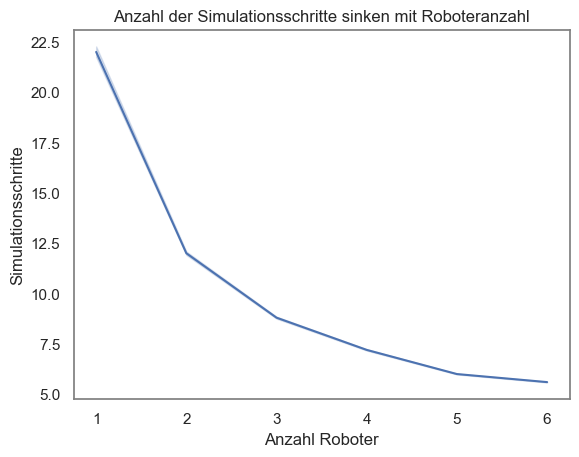

In [13]:
# 3 plots with same y axis
sns.lineplot(data=df, x="n_robot_agents", y="Step")


plt.title("Anzahl der Simulationsschritte sinken mit Roboteranzahl") # TODO: linear???
plt.xlabel("Anzahl Roboter")
plt.ylabel("Simulationsschritte")
plt.xticks(
    range(
        df["n_robot_agents"].min(),
        df["n_robot_agents"].max() + 1,
    )
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/simulationsteps_per_agent.png",
    dpi=300,
    bbox_inches="tight",
)